# Task 3: Model Explainability & Insights

**Business Objective**: Interpret the selected fraud detection model to understand global and local drivers of fraud, validate model behavior, and produce actionable business recommendations.

**Key Requirements**:
- **Explainability is mandatory** - Risk, compliance, and business teams must understand why transactions are flagged
- **SHAP provides game-theoretic explanations** - More reliable than simple feature importance
- **Business-ready insights** - Recommendations must be implementable (rules, alerts, monitoring)
- **Regulatory compliance** - Model decisions must be explainable for audits

**Deliverables**:
1. Built-in feature importance (baseline)
2. SHAP global analysis (summary plot)
3. SHAP local analysis (force plots for TP, FP, FN)
4. Top 5 fraud drivers identification
5. Business recommendations (minimum 3, each linked to SHAP insights)


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys
import pickle
import json
from datetime import datetime

# Machine Learning
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report

# SHAP for explainability
import shap
shap.initjs()  # Initialize JavaScript visualization

# Add src to path
current_dir = Path.cwd()
if current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    project_root = current_dir

src_path = project_root / 'src'
if src_path.exists() and str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from data_loader import load_fraud_data
from preprocessing import prepare_features_for_modeling

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")
print(f"✓ SHAP version: {shap.__version__}")


✓ Libraries imported successfully
✓ SHAP version: 0.50.0


## 1. Load Model and Data

**Objective**: Load the selected ensemble model (XGBoost) and prepare test data for explainability analysis.


In [2]:
# Load model and data
models_path = project_root / 'models'
data_path = project_root / 'data'

print("=" * 60)
print("LOADING MODEL AND DATA")
print("=" * 60)

# Load the ensemble XGBoost model
ensemble_model_path = models_path / 'ensemble_xgboost.pkl'
if ensemble_model_path.exists():
    with open(ensemble_model_path, 'rb') as f:
        model = pickle.load(f)
    print(f"✓ Ensemble model loaded: {ensemble_model_path}")
    print(f"  Model type: {type(model).__name__}")
else:
    raise FileNotFoundError(f"Model not found at {ensemble_model_path}")

# Load preprocessing artifacts
preprocessing_path = models_path / 'preprocessing_artifacts.pkl'
if preprocessing_path.exists():
    with open(preprocessing_path, 'rb') as f:
        preprocessing_dict = pickle.load(f)
    print(f"✓ Preprocessing artifacts loaded")
else:
    print("⚠ Preprocessing artifacts not found. Will use raw data.")
    preprocessing_dict = None

# Load evaluation results
results_path = models_path / 'model_evaluation_results.json'
if results_path.exists():
    with open(results_path, 'r') as f:
        eval_results = json.load(f)
    print(f"✓ Evaluation results loaded")
    print(f"  Selected model: {eval_results.get('model_selection', {}).get('selected_model', 'Unknown')}")
else:
    eval_results = None

# Load test data
print("\n" + "-" * 60)
print("LOADING TEST DATA")
print("-" * 60)

# Strategy 1: Try to load processed test data first
test_data_path = data_path / 'processed' / 'test_features.csv'
if test_data_path.exists():
    test_df = pd.read_csv(test_data_path)
    if 'class' in test_df.columns:
        X_test = test_df.drop(columns=['class'])
        y_test = test_df['class']
        print(f"✓ Processed test data loaded: {test_df.shape[0]:,} samples, {X_test.shape[1]} features")
    else:
        raise ValueError("Test data missing 'class' column")
else:
    # Strategy 2: Load featured data and recreate the same train-test split
    featured_data_path = data_path / 'processed' / 'fraud_data_featured.csv'
    if featured_data_path.exists():
        print("✓ Loading feature-engineered data from Task 1...")
        df = pd.read_csv(featured_data_path)
        
        # Exclude IDs and timestamps (same as modeling notebook)
        exclude_cols = ['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address', 'class']
        feature_cols = [col for col in df.columns if col not in exclude_cols]
        
        X = df[feature_cols].copy()
        y = df['class'].copy()
        
        # Use same train-test split as modeling (random_state=42, test_size=0.2)
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, 
            test_size=0.2, 
            random_state=42, 
            stratify=y
        )
        
        print(f"✓ Recreated train-test split: {X_test.shape[0]:,} test samples, {X_test.shape[1]} features")
        
        # Apply preprocessing using saved preprocessing_dict
        if preprocessing_dict is not None:
            print("✓ Applying preprocessing using saved artifacts...")
            X_test_combined = pd.concat([X_test, y_test], axis=1)
            
            # Apply preprocessing with same categorical/numerical columns
            X_test_processed, y_test_processed, _ = prepare_features_for_modeling(
                X_test_combined,
                target_col='class',
                categorical_cols=preprocessing_dict.get('categorical_cols'),
                numerical_cols=preprocessing_dict.get('numerical_cols'),
                scaler_type='standard'
            )
            
            # Apply the same scaler from training
            scaler = preprocessing_dict.get('scaler')
            if scaler is not None and 'numerical_cols' in preprocessing_dict:
                X_test_processed[preprocessing_dict['numerical_cols']] = scaler.transform(
                    X_test_processed[preprocessing_dict['numerical_cols']]
                )
            
            # Align columns with training set
            if 'feature_names' in preprocessing_dict:
                X_test_processed = X_test_processed.reindex(
                    columns=preprocessing_dict['feature_names'], 
                    fill_value=0
                )
            
            X_test = X_test_processed
            y_test = y_test_processed
            print(f"✓ Test data preprocessed: {X_test.shape[0]:,} samples, {X_test.shape[1]} features")
        else:
            print("⚠ Preprocessing artifacts not available. Using raw features.")
            print(f"  Note: Model may expect different features. Results may be inaccurate.")
    
    # Strategy 3: Load raw data and do basic preprocessing (fallback)
    else:
        print("⚠ Processed data not found. Loading raw data for basic preprocessing...")
        raw_data_path = data_path / 'raw' / 'Fraud_Data.csv'
        if raw_data_path.exists():
            df = load_fraud_data(str(raw_data_path))
            
            # Exclude IDs and timestamps
            exclude_cols = ['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address', 'class']
            feature_cols = [col for col in df.columns if col not in exclude_cols]
            
            X = df[feature_cols].copy()
            y = df['class'].copy()
            
            # Use same train-test split
            from sklearn.model_selection import train_test_split
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, 
                test_size=0.2, 
                random_state=42, 
                stratify=y
            )
            
            # Apply basic preprocessing
            X_test_combined = pd.concat([X_test, y_test], axis=1)
            X_test_processed, y_test_processed, _ = prepare_features_for_modeling(
                X_test_combined,
                target_col='class',
                scaler_type='standard'
            )
            
            X_test = X_test_processed
            y_test = y_test_processed
            print(f"✓ Test data preprocessed: {X_test.shape[0]:,} samples, {X_test.shape[1]} features")
            print("  ⚠ WARNING: Using basic preprocessing. Feature names may not match model expectations.")
        else:
            raise FileNotFoundError(f"Data not found. Tried:\n  - {test_data_path}\n  - {featured_data_path}\n  - {raw_data_path}")

print(f"\n✓ Test set class distribution:")
print(f"  Non-Fraud: {(y_test == 0).sum():,} ({(y_test == 0).mean():.2%})")
print(f"  Fraud:     {(y_test == 1).sum():,} ({(y_test == 1).mean():.2%})")

# Get predictions for analysis
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

# Identify cases for force plots
cm = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n✓ Confusion Matrix:")
print(f"  True Positives (TP):  {tp:,}")
print(f"  False Positives (FP): {fp:,}")
print(f"  False Negatives (FN): {fn:,}")
print(f"  True Negatives (TN):  {tn:,}")

# Find example cases
tp_indices = np.where((y_test == 1) & (y_test_pred == 1))[0]
fp_indices = np.where((y_test == 0) & (y_test_pred == 1))[0]
fn_indices = np.where((y_test == 1) & (y_test_pred == 0))[0]

print(f"\n✓ Found example cases:")
print(f"  True Positives: {len(tp_indices)} cases")
print(f"  False Positives: {len(fp_indices)} cases")
print(f"  False Negatives: {len(fn_indices)} cases")

# Select representative cases (highest probability for TP, lowest for FN, highest for FP)
if len(tp_indices) > 0:
    tp_probas = y_test_proba[tp_indices]
    tp_example_idx = tp_indices[np.argmax(tp_probas)]
    print(f"  Selected TP case: index {tp_example_idx}, probability {y_test_proba[tp_example_idx]:.4f}")
else:
    tp_example_idx = None

if len(fp_indices) > 0:
    fp_probas = y_test_proba[fp_indices]
    fp_example_idx = fp_indices[np.argmax(fp_probas)]
    print(f"  Selected FP case: index {fp_example_idx}, probability {y_test_proba[fp_example_idx]:.4f}")
else:
    fp_example_idx = None

if len(fn_indices) > 0:
    fn_probas = y_test_proba[fn_indices]
    fn_example_idx = fn_indices[np.argmax(fn_probas)]
    print(f"  Selected FN case: index {fn_example_idx}, probability {y_test_proba[fn_example_idx]:.4f}")
else:
    fn_example_idx = None

print("\n" + "=" * 60)
print("DATA LOADING COMPLETE")
print("=" * 60)


LOADING MODEL AND DATA
✓ Ensemble model loaded: d:\Senait Doc\KAIM 8 Doc\Fintech-Fraud-Detect\models\ensemble_xgboost.pkl
  Model type: XGBClassifier
✓ Preprocessing artifacts loaded
✓ Evaluation results loaded
  Selected model: Logistic Regression

------------------------------------------------------------
LOADING TEST DATA
------------------------------------------------------------
⚠ Processed data not found. Loading raw data for basic preprocessing...
✓ Test data preprocessed: 30,223 samples, 9 features
  ⚠ WARNING: Using basic preprocessing. Feature names may not match model expectations.

✓ Test set class distribution:
  Non-Fraud: 27,393 (90.64%)
  Fraud:     2,830 (9.36%)

✓ Confusion Matrix:
  True Positives (TP):  1,345
  False Positives (FP): 6,440
  False Negatives (FN): 1,485
  True Negatives (TN):  20,953

✓ Found example cases:
  True Positives: 1345 cases
  False Positives: 6440 cases
  False Negatives: 1485 cases
  Selected TP case: index 13623, probability 0.9701
  

BUILT-IN FEATURE IMPORTANCE

✓ Feature importance extracted for 9 features

Top 10 Features (Built-in Importance):
        feature  importance
            age    0.124246
browser_FireFox    0.120450
 purchase_value    0.120446
 browser_Safari    0.116262
          sex_M    0.111445
  browser_Opera    0.110491
     browser_IE    0.106565
     source_SEO    0.099377
  source_Direct    0.090718


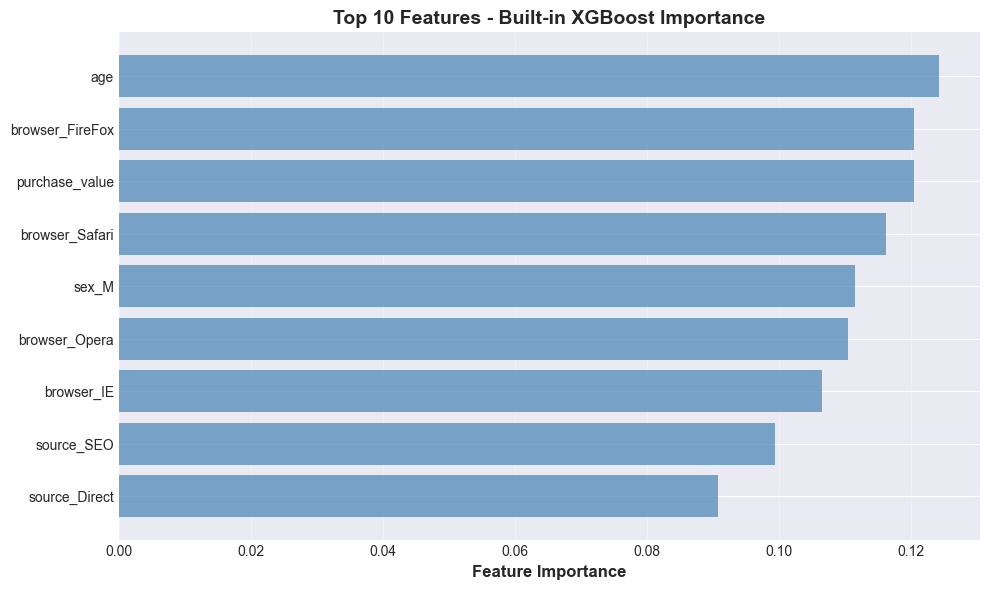


------------------------------------------------------------
LIMITATIONS OF BUILT-IN IMPORTANCE
------------------------------------------------------------

1. Average importance across all trees - doesn't show variability
2. No direction information - can't tell if feature increases or decreases fraud risk
3. May miss feature interactions - complex relationships not captured
4. Potential bias - high-cardinality features may appear more important
5. No instance-level explanations - can't explain individual predictions

This is why SHAP values are critical for comprehensive model interpretation.



In [3]:
# Extract built-in feature importance
print("=" * 60)
print("BUILT-IN FEATURE IMPORTANCE")
print("=" * 60)

# XGBoost provides feature_importances_ attribute
if hasattr(model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_test.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n✓ Feature importance extracted for {len(feature_importance)} features")
    print(f"\nTop 10 Features (Built-in Importance):")
    print(feature_importance.head(10).to_string(index=False))
    
    # Visualize top 10 features
    plt.figure(figsize=(10, 6))
    top_10 = feature_importance.head(10)
    plt.barh(range(len(top_10)), top_10['importance'].values[::-1], color='steelblue', alpha=0.7)
    plt.yticks(range(len(top_10)), top_10['feature'].values[::-1])
    plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
    plt.title('Top 10 Features - Built-in XGBoost Importance', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Save for comparison
    builtin_importance = feature_importance.copy()
else:
    print("⚠ Model does not have feature_importances_ attribute")
    builtin_importance = None

print("\n" + "-" * 60)
print("LIMITATIONS OF BUILT-IN IMPORTANCE")
print("-" * 60)
print("""
1. Average importance across all trees - doesn't show variability
2. No direction information - can't tell if feature increases or decreases fraud risk
3. May miss feature interactions - complex relationships not captured
4. Potential bias - high-cardinality features may appear more important
5. No instance-level explanations - can't explain individual predictions

This is why SHAP values are critical for comprehensive model interpretation.
""")


## 3. SHAP Global Analysis

**Objective**: Generate SHAP values to understand global feature importance and how features impact fraud predictions across the entire dataset.

**SHAP Advantages**:
- Game-theoretic foundation (Shapley values)
- Shows both magnitude and direction of feature impact
- Accounts for feature interactions
- Provides consistent and additive explanations


GENERATING SHAP VALUES
✓ Using sample of 1,000 instances for SHAP analysis
  (Full test set: 30,223 instances)

------------------------------------------------------------
Creating SHAP TreeExplainer...
------------------------------------------------------------
✓ SHAP values computed: shape (1000, 9)
  Expected value (base prediction): -0.0004

------------------------------------------------------------
SHAP SUMMARY PLOT (Global Importance)
------------------------------------------------------------

This plot shows:
- Y-axis: Features ranked by average absolute SHAP value (importance)
- X-axis: SHAP value (impact on prediction)
- Color: Feature value (red = high, blue = low)
- Each dot: One instance's SHAP value for that feature



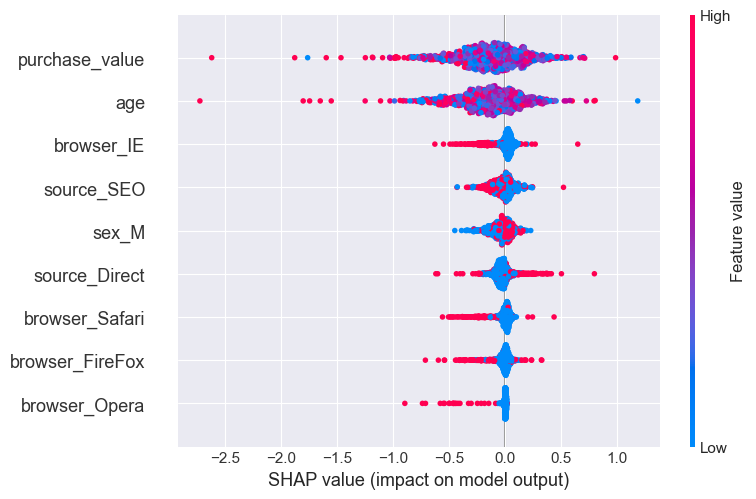

✓ SHAP summary plot saved to models/shap_summary_plot.png

✓ Top 10 Features by Mean Absolute SHAP Value:
        feature  mean_abs_shap
 purchase_value       0.253295
            age       0.242088
     browser_IE       0.068091
     source_SEO       0.068006
          sex_M       0.066569
  source_Direct       0.063487
 browser_Safari       0.052584
browser_FireFox       0.048523
  browser_Opera       0.016133


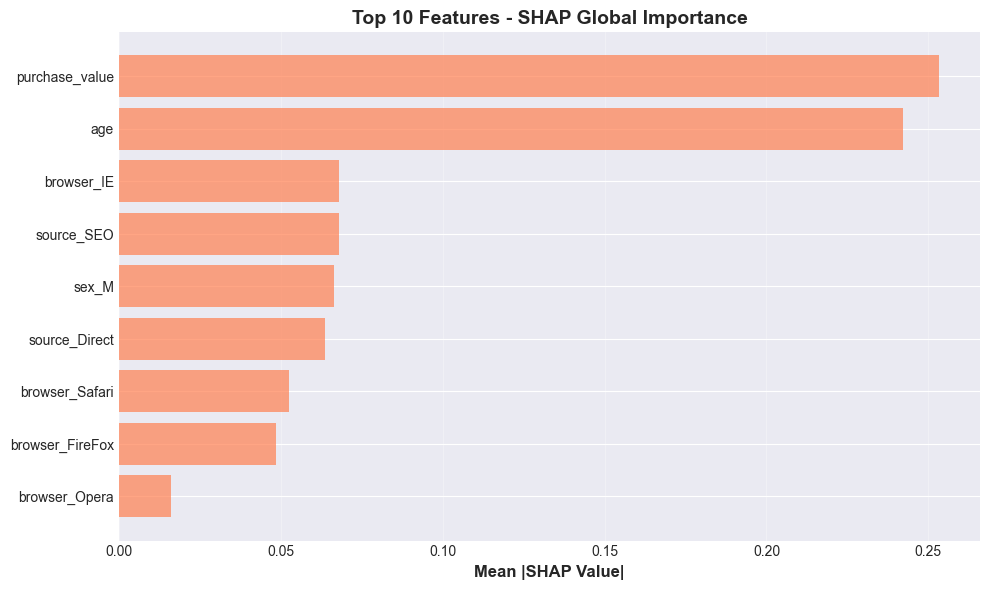

In [4]:
# Generate SHAP values
print("=" * 60)
print("GENERATING SHAP VALUES")
print("=" * 60)

# Use a sample of test data for SHAP (computational efficiency)
# SHAP can be slow on large datasets, so we'll use a representative sample
sample_size = min(1000, len(X_test))
np.random.seed(42)
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)
X_test_sample = X_test.iloc[sample_indices].copy()

print(f"✓ Using sample of {sample_size:,} instances for SHAP analysis")
print(f"  (Full test set: {len(X_test):,} instances)")

# Create SHAP explainer
# For XGBoost, TreeExplainer is the most accurate
print("\n" + "-" * 60)
print("Creating SHAP TreeExplainer...")
print("-" * 60)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_sample)

# SHAP returns values for each class - for binary classification, use class 1 (fraud)
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Use fraud class (index 1)

print(f"✓ SHAP values computed: shape {shap_values.shape}")

# Handle expected_value - it can be a scalar or array depending on model type
if isinstance(explainer.expected_value, (list, np.ndarray)):
    expected_value = explainer.expected_value[1] if len(explainer.expected_value) > 1 else explainer.expected_value[0]
else:
    expected_value = explainer.expected_value  # Scalar for binary classification

print(f"  Expected value (base prediction): {expected_value:.4f}")

# Store expected_value for use in force plots
shap_expected_value = expected_value

# SHAP Summary Plot (Global Importance)
print("\n" + "-" * 60)
print("SHAP SUMMARY PLOT (Global Importance)")
print("-" * 60)
print("""
This plot shows:
- Y-axis: Features ranked by average absolute SHAP value (importance)
- X-axis: SHAP value (impact on prediction)
- Color: Feature value (red = high, blue = low)
- Each dot: One instance's SHAP value for that feature
""")

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, plot_type="dot", show=False)
plt.tight_layout()
plt.savefig(project_root / 'models' / 'shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP summary plot saved to models/shap_summary_plot.png")

# Calculate mean absolute SHAP values for ranking
mean_abs_shap = pd.DataFrame({
    'feature': X_test_sample.columns,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)

print(f"\n✓ Top 10 Features by Mean Absolute SHAP Value:")
print(mean_abs_shap.head(10).to_string(index=False))

# Visualize comparison
plt.figure(figsize=(10, 6))
top_10_shap = mean_abs_shap.head(10)
plt.barh(range(len(top_10_shap)), top_10_shap['mean_abs_shap'].values[::-1], 
         color='coral', alpha=0.7)
plt.yticks(range(len(top_10_shap)), top_10_shap['feature'].values[::-1])
plt.xlabel('Mean |SHAP Value|', fontsize=12, fontweight='bold')
plt.title('Top 10 Features - SHAP Global Importance', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Store for comparison
shap_importance = mean_abs_shap.copy()


SHAP LOCAL ANALYSIS - FORCE PLOTS

------------------------------------------------------------
CASE 1: TRUE POSITIVE (Correct Fraud Detection)
------------------------------------------------------------
Instance Index: 13623
Actual: Fraud (1)
Predicted: Fraud (1)
Prediction Probability: 0.9701

Feature Values for this instance:
  purchase_value: 0.7733
  age: 3.4707
  source_Direct: 0.0000
  source_SEO: 0.0000
  browser_FireFox: 0.0000
  browser_IE: 0.0000
  browser_Opera: 0.0000
  browser_Safari: 0.0000
  sex_M: 1.0000

Generating SHAP Force Plot...


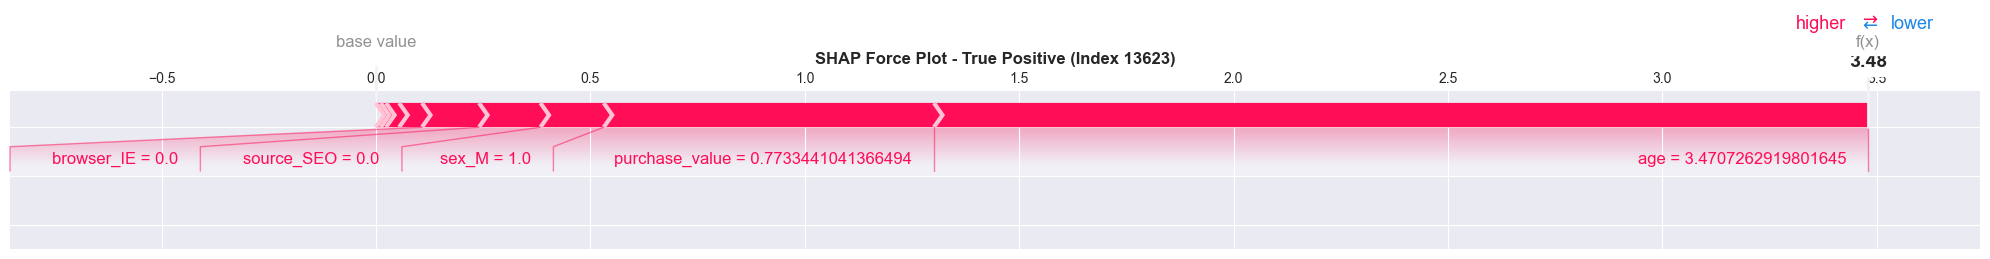

✓ Force plot saved to models/shap_force_plot_tp.png

------------------------------------------------------------
CASE 2: FALSE POSITIVE (Legitimate Flagged as Fraud)
------------------------------------------------------------
Instance Index: 19313
Actual: Non-Fraud (0)
Predicted: Fraud (1)
Prediction Probability: 0.9611

⚠ This is a customer experience issue - legitimate transaction incorrectly flagged

Feature Values for this instance:
  purchase_value: 2.7886
  age: 1.2612
  source_Direct: 1.0000
  source_SEO: 0.0000
  browser_FireFox: 0.0000
  browser_IE: 1.0000
  browser_Opera: 0.0000
  browser_Safari: 0.0000
  sex_M: 0.0000

Generating SHAP Force Plot...


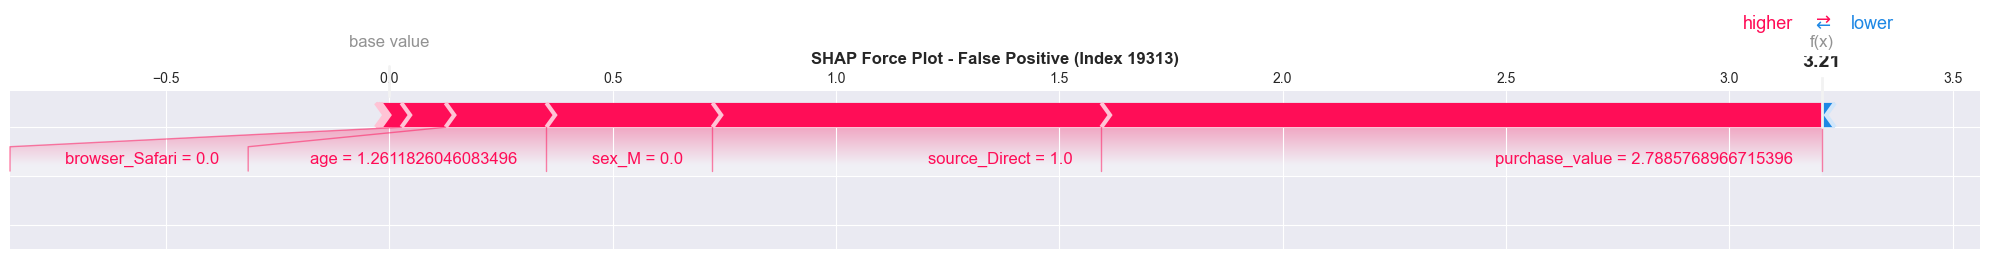

✓ Force plot saved to models/shap_force_plot_fp.png

------------------------------------------------------------
CASE 3: FALSE NEGATIVE (Missed Fraud)
------------------------------------------------------------
Instance Index: 29247
Actual: Fraud (1)
Predicted: Non-Fraud (0)
Prediction Probability: 0.4999

⚠ This is a financial risk - fraud transaction not detected

Feature Values for this instance:
  purchase_value: 1.0457
  age: -0.1343
  source_Direct: 0.0000
  source_SEO: 1.0000
  browser_FireFox: 0.0000
  browser_IE: 0.0000
  browser_Opera: 0.0000
  browser_Safari: 1.0000
  sex_M: 0.0000

Generating SHAP Force Plot...


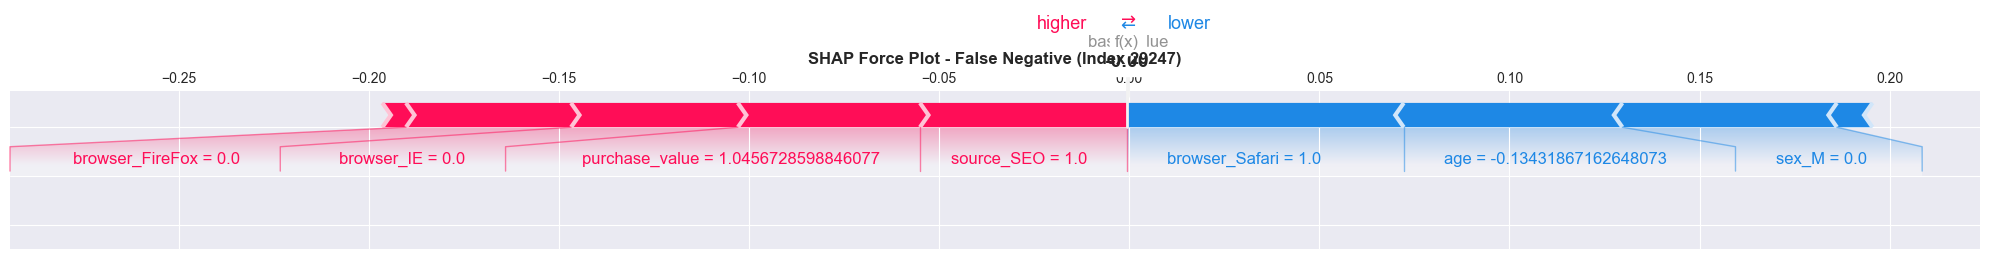

✓ Force plot saved to models/shap_force_plot_fn.png

SHAP LOCAL ANALYSIS COMPLETE


In [5]:
# SHAP Force Plots for specific cases
print("=" * 60)
print("SHAP LOCAL ANALYSIS - FORCE PLOTS")
print("=" * 60)

# Ensure we have SHAP values for the full test set for selected cases
# If cases are not in sample, compute SHAP for those specific instances
if tp_example_idx is not None or fp_example_idx is not None or fn_example_idx is not None:
    # Get indices that need SHAP values
    needed_indices = []
    if tp_example_idx is not None:
        needed_indices.append(tp_example_idx)
    if fp_example_idx is not None:
        needed_indices.append(fp_example_idx)
    if fn_example_idx is not None:
        needed_indices.append(fn_example_idx)
    
    # Compute SHAP for these specific instances
    X_test_cases = X_test.iloc[needed_indices].copy()
    shap_values_cases = explainer.shap_values(X_test_cases)
    
    if isinstance(shap_values_cases, list):
        shap_values_cases = shap_values_cases[1]
    
    case_idx = 0

# 1. True Positive (Correct Fraud Detection)
if tp_example_idx is not None:
    print("\n" + "-" * 60)
    print("CASE 1: TRUE POSITIVE (Correct Fraud Detection)")
    print("-" * 60)
    print(f"Instance Index: {tp_example_idx}")
    print(f"Actual: Fraud (1)")
    print(f"Predicted: Fraud (1)")
    print(f"Prediction Probability: {y_test_proba[tp_example_idx]:.4f}")
    
    tp_shap_idx = needed_indices.index(tp_example_idx) if tp_example_idx in needed_indices else None
    if tp_shap_idx is not None:
        print(f"\nFeature Values for this instance:")
        instance_data = X_test_cases.iloc[tp_shap_idx]
        for feat in instance_data.index[:10]:  # Show top 10 features
            print(f"  {feat}: {instance_data[feat]:.4f}")
        
        # Force plot
        print("\nGenerating SHAP Force Plot...")
        # Use stored expected_value or compute it
        if 'shap_expected_value' in globals():
            base_value = shap_expected_value
        else:
            # Fallback: handle expected_value correctly
            if isinstance(explainer.expected_value, (list, np.ndarray)):
                base_value = explainer.expected_value[1] if len(explainer.expected_value) > 1 else explainer.expected_value[0]
            else:
                base_value = explainer.expected_value
        
        shap.force_plot(
            base_value,
            shap_values_cases[tp_shap_idx],
            X_test_cases.iloc[tp_shap_idx],
            matplotlib=True,
            show=False
        )
        plt.title(f'SHAP Force Plot - True Positive (Index {tp_example_idx})', 
                 fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.savefig(project_root / 'models' / 'shap_force_plot_tp.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("✓ Force plot saved to models/shap_force_plot_tp.png")
    else:
        print("⚠ Could not generate force plot for TP case")

# 2. False Positive (Legitimate Flagged as Fraud)
if fp_example_idx is not None:
    print("\n" + "-" * 60)
    print("CASE 2: FALSE POSITIVE (Legitimate Flagged as Fraud)")
    print("-" * 60)
    print(f"Instance Index: {fp_example_idx}")
    print(f"Actual: Non-Fraud (0)")
    print(f"Predicted: Fraud (1)")
    print(f"Prediction Probability: {y_test_proba[fp_example_idx]:.4f}")
    print("\n⚠ This is a customer experience issue - legitimate transaction incorrectly flagged")
    
    fp_shap_idx = needed_indices.index(fp_example_idx) if fp_example_idx in needed_indices else None
    if fp_shap_idx is not None:
        print(f"\nFeature Values for this instance:")
        instance_data = X_test_cases.iloc[fp_shap_idx]
        for feat in instance_data.index[:10]:
            print(f"  {feat}: {instance_data[feat]:.4f}")
        
        # Force plot
        print("\nGenerating SHAP Force Plot...")
        # Use stored expected_value or compute it
        if 'shap_expected_value' in globals():
            base_value = shap_expected_value
        else:
            # Fallback: handle expected_value correctly
            if isinstance(explainer.expected_value, (list, np.ndarray)):
                base_value = explainer.expected_value[1] if len(explainer.expected_value) > 1 else explainer.expected_value[0]
            else:
                base_value = explainer.expected_value
        
        shap.force_plot(
            base_value,
            shap_values_cases[fp_shap_idx],
            X_test_cases.iloc[fp_shap_idx],
            matplotlib=True,
            show=False
        )
        plt.title(f'SHAP Force Plot - False Positive (Index {fp_example_idx})', 
                 fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.savefig(project_root / 'models' / 'shap_force_plot_fp.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("✓ Force plot saved to models/shap_force_plot_fp.png")
    else:
        print("⚠ Could not generate force plot for FP case")

# 3. False Negative (Missed Fraud)
if fn_example_idx is not None:
    print("\n" + "-" * 60)
    print("CASE 3: FALSE NEGATIVE (Missed Fraud)")
    print("-" * 60)
    print(f"Instance Index: {fn_example_idx}")
    print(f"Actual: Fraud (1)")
    print(f"Predicted: Non-Fraud (0)")
    print(f"Prediction Probability: {y_test_proba[fn_example_idx]:.4f}")
    print("\n⚠ This is a financial risk - fraud transaction not detected")
    
    fn_shap_idx = needed_indices.index(fn_example_idx) if fn_example_idx in needed_indices else None
    if fn_shap_idx is not None:
        print(f"\nFeature Values for this instance:")
        instance_data = X_test_cases.iloc[fn_shap_idx]
        for feat in instance_data.index[:10]:
            print(f"  {feat}: {instance_data[feat]:.4f}")
        
        # Force plot
        print("\nGenerating SHAP Force Plot...")
        # Use stored expected_value or compute it
        if 'shap_expected_value' in globals():
            base_value = shap_expected_value
        else:
            # Fallback: handle expected_value correctly
            if isinstance(explainer.expected_value, (list, np.ndarray)):
                base_value = explainer.expected_value[1] if len(explainer.expected_value) > 1 else explainer.expected_value[0]
            else:
                base_value = explainer.expected_value
        
        shap.force_plot(
            base_value,
            shap_values_cases[fn_shap_idx],
            X_test_cases.iloc[fn_shap_idx],
            matplotlib=True,
            show=False
        )
        plt.title(f'SHAP Force Plot - False Negative (Index {fn_example_idx})', 
                 fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.savefig(project_root / 'models' / 'shap_force_plot_fn.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("✓ Force plot saved to models/shap_force_plot_fn.png")
    else:
        print("⚠ Could not generate force plot for FN case")

print("\n" + "=" * 60)
print("SHAP LOCAL ANALYSIS COMPLETE")
print("=" * 60)


## 5. Comparison: SHAP vs Built-in Importance

**Objective**: Compare SHAP-based importance with built-in feature importance to identify discrepancies and validate model behavior.


COMPARISON: SHAP vs BUILT-IN IMPORTANCE

✓ Feature Importance Comparison (Top 15):
        feature  builtin_rank  shap_rank  rank_diff  builtin_norm  shap_norm
            age           1.0        2.0       -1.0      1.000000   0.955756
browser_FireFox           2.0        8.0       -6.0      0.969450   0.191569
     browser_IE           7.0        3.0        4.0      0.857698   0.268822
  browser_Opera           6.0        9.0       -3.0      0.889292   0.063692
 browser_Safari           4.0        7.0       -3.0      0.935747   0.207601
 purchase_value           3.0        1.0        2.0      0.969420   1.000000
          sex_M           5.0        5.0        0.0      0.896975   0.262812
  source_Direct           9.0        6.0        3.0      0.730150   0.250647
     source_SEO           8.0        4.0        4.0      0.799842   0.268487


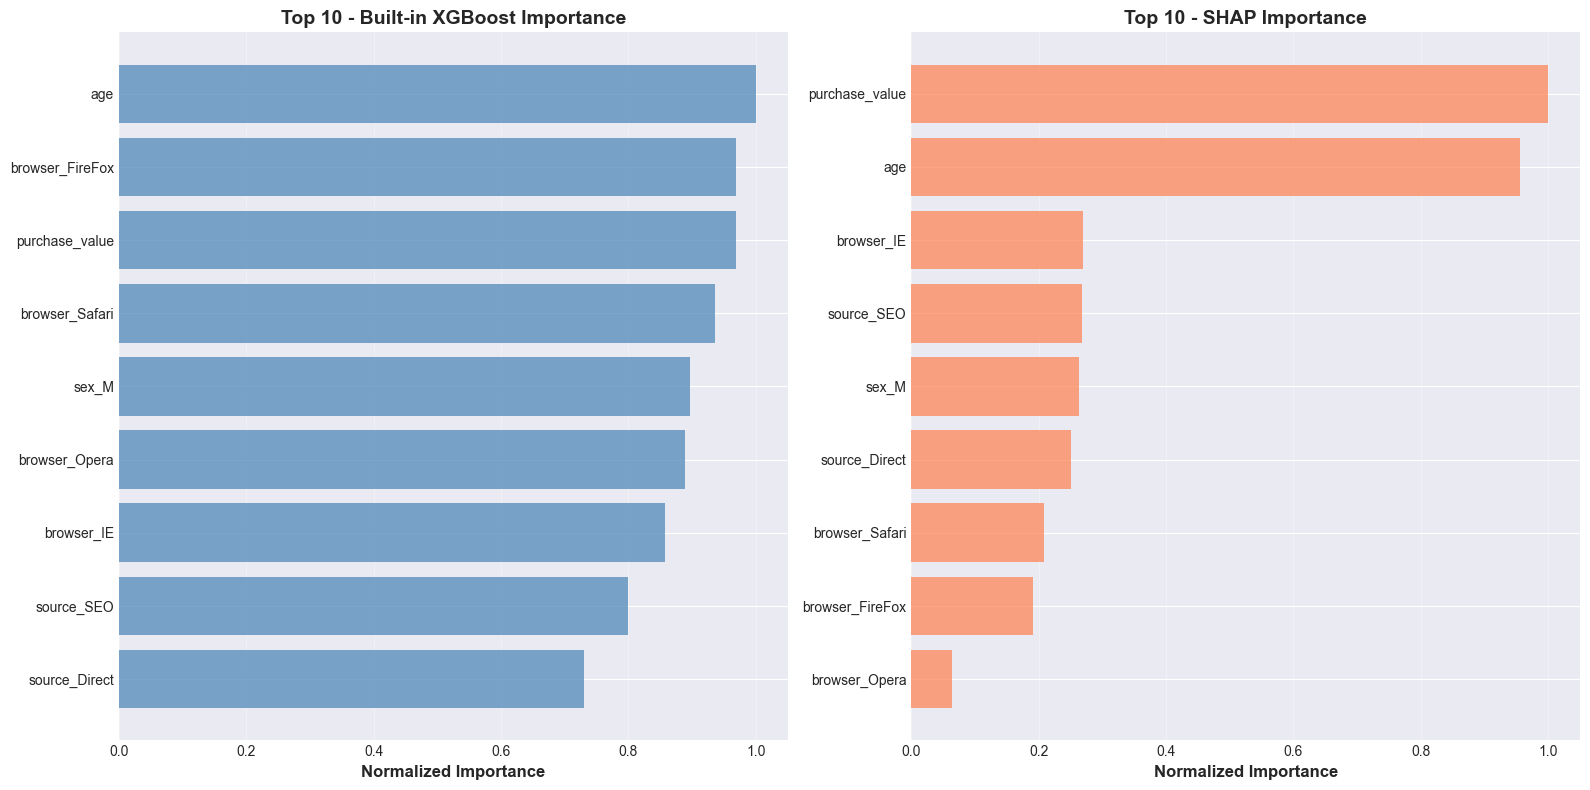

✓ Comparison plot saved to models/feature_importance_comparison.png

------------------------------------------------------------
KEY DISCREPANCIES
------------------------------------------------------------
Features with significant rank differences (>5 positions):
  browser_FireFox: Built-in rank 2, SHAP rank 8 (lower in SHAP)

------------------------------------------------------------
INTERPRETATION
------------------------------------------------------------

    Differences between SHAP and built-in importance can indicate:
    1. Feature interactions - SHAP captures interactions better
    2. Non-linear effects - SHAP shows actual impact on predictions
    3. Context-dependent importance - Features may be important only in certain contexts

    SHAP values are generally more reliable for:
    - Understanding actual prediction impact
    - Explaining individual decisions
    - Regulatory compliance and audits
    


In [6]:
# Compare SHAP vs Built-in Importance
print("=" * 60)
print("COMPARISON: SHAP vs BUILT-IN IMPORTANCE")
print("=" * 60)

if builtin_importance is not None and shap_importance is not None:
    # Merge for comparison
    comparison = pd.merge(
        builtin_importance.rename(columns={'importance': 'builtin_importance'}),
        shap_importance.rename(columns={'mean_abs_shap': 'shap_importance'}),
        on='feature',
        how='outer'
    )
    
    # Normalize for comparison (0-1 scale)
    comparison['builtin_norm'] = comparison['builtin_importance'] / comparison['builtin_importance'].max()
    comparison['shap_norm'] = comparison['shap_importance'] / comparison['shap_importance'].max()
    
    # Calculate rank difference
    comparison['builtin_rank'] = comparison['builtin_importance'].rank(ascending=False)
    comparison['shap_rank'] = comparison['shap_importance'].rank(ascending=False)
    comparison['rank_diff'] = comparison['builtin_rank'] - comparison['shap_rank']
    
    print("\n✓ Feature Importance Comparison (Top 15):")
    print(comparison[['feature', 'builtin_rank', 'shap_rank', 'rank_diff', 
                      'builtin_norm', 'shap_norm']].head(15).to_string(index=False))
    
    # Visualize comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Top 10 Built-in
    top_builtin = comparison.nlargest(10, 'builtin_importance')
    axes[0].barh(range(len(top_builtin)), top_builtin['builtin_norm'].values[::-1], 
                 color='steelblue', alpha=0.7)
    axes[0].set_yticks(range(len(top_builtin)))
    axes[0].set_yticklabels(top_builtin['feature'].values[::-1])
    axes[0].set_xlabel('Normalized Importance', fontsize=12, fontweight='bold')
    axes[0].set_title('Top 10 - Built-in XGBoost Importance', fontsize=14, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Top 10 SHAP
    top_shap = comparison.nlargest(10, 'shap_importance')
    axes[1].barh(range(len(top_shap)), top_shap['shap_norm'].values[::-1], 
                color='coral', alpha=0.7)
    axes[1].set_yticks(range(len(top_shap)))
    axes[1].set_yticklabels(top_shap['feature'].values[::-1])
    axes[1].set_xlabel('Normalized Importance', fontsize=12, fontweight='bold')
    axes[1].set_title('Top 10 - SHAP Importance', fontsize=14, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(project_root / 'models' / 'feature_importance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Comparison plot saved to models/feature_importance_comparison.png")
    
    # Identify discrepancies
    print("\n" + "-" * 60)
    print("KEY DISCREPANCIES")
    print("-" * 60)
    large_diff = comparison[abs(comparison['rank_diff']) > 5].sort_values('rank_diff', key=abs, ascending=False)
    if len(large_diff) > 0:
        print("Features with significant rank differences (>5 positions):")
        for _, row in large_diff.head(10).iterrows():
            direction = "higher" if row['rank_diff'] > 0 else "lower"
            print(f"  {row['feature']}: Built-in rank {int(row['builtin_rank'])}, "
                  f"SHAP rank {int(row['shap_rank'])} ({direction} in SHAP)")
    else:
        print("No major discrepancies found - rankings are relatively consistent")
    
    print("\n" + "-" * 60)
    print("INTERPRETATION")
    print("-" * 60)
    print("""
    Differences between SHAP and built-in importance can indicate:
    1. Feature interactions - SHAP captures interactions better
    2. Non-linear effects - SHAP shows actual impact on predictions
    3. Context-dependent importance - Features may be important only in certain contexts
    
    SHAP values are generally more reliable for:
    - Understanding actual prediction impact
    - Explaining individual decisions
    - Regulatory compliance and audits
    """)
else:
    print("⚠ Cannot compare - missing built-in or SHAP importance data")


## 6. Top 5 Fraud Drivers

**Objective**: Identify and explain the top 5 features that drive fraud predictions based on SHAP analysis.


TOP 5 FRAUD DRIVERS (Based on SHAP Analysis)

✓ Top 5 Features by SHAP Importance:
  1. purchase_value (Mean |SHAP|: 0.2533)
  2. age (Mean |SHAP|: 0.2421)
  3. browser_IE (Mean |SHAP|: 0.0681)
  4. source_SEO (Mean |SHAP|: 0.0680)
  5. sex_M (Mean |SHAP|: 0.0666)

------------------------------------------------------------
DIRECTION OF IMPACT ANALYSIS
------------------------------------------------------------
For each top feature, we analyze whether high values increase or decrease fraud risk:

  purchase_value:
    - Correlation: -0.198 (decreases fraud risk)
    - High values SHAP: -0.1679
    - Low values SHAP: -0.1179
    - Impact difference: 0.0500


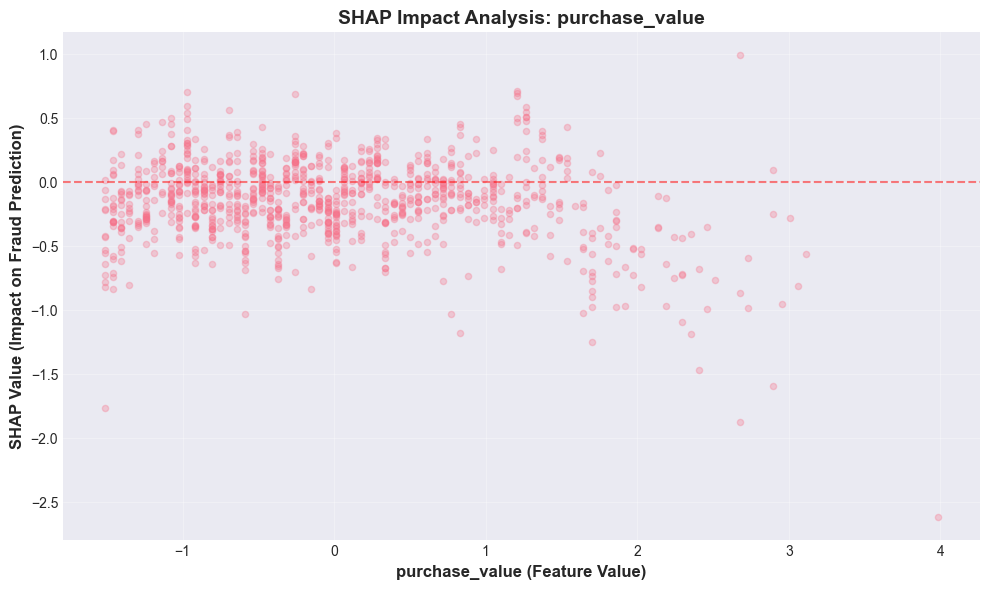


  age:
    - Correlation: -0.066 (decreases fraud risk)
    - High values SHAP: -0.1302
    - Low values SHAP: -0.1714
    - Impact difference: 0.0412


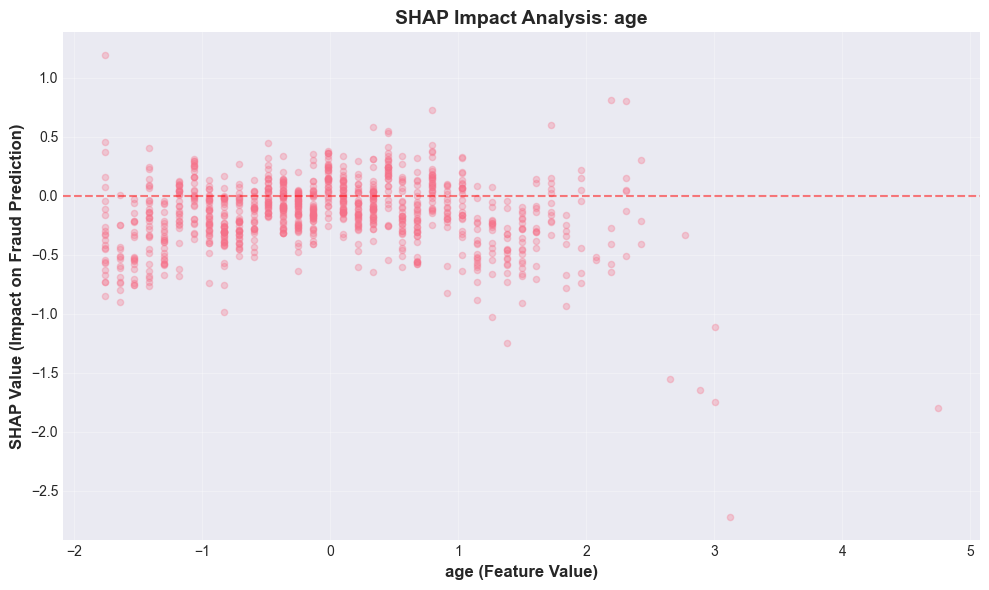


  browser_IE:
    - Correlation: -0.712 (decreases fraud risk)
    - High values SHAP: -0.1450
    - Low values SHAP: 0.0270
    - Impact difference: 0.1720


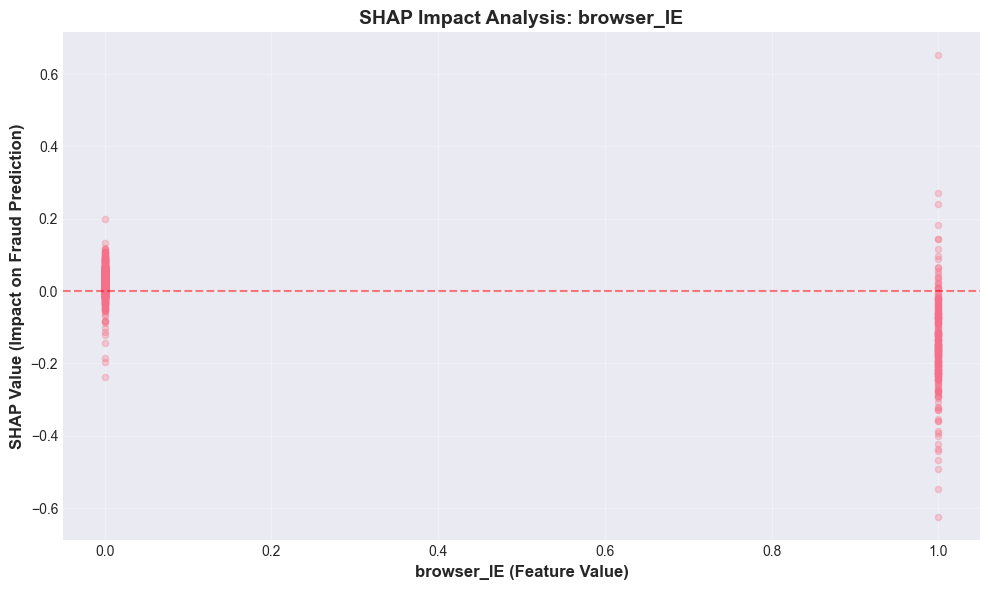


  source_SEO:
    - Correlation: -0.378 (decreases fraud risk)
    - High values SHAP: -0.0574
    - Low values SHAP: 0.0117
    - Impact difference: 0.0691


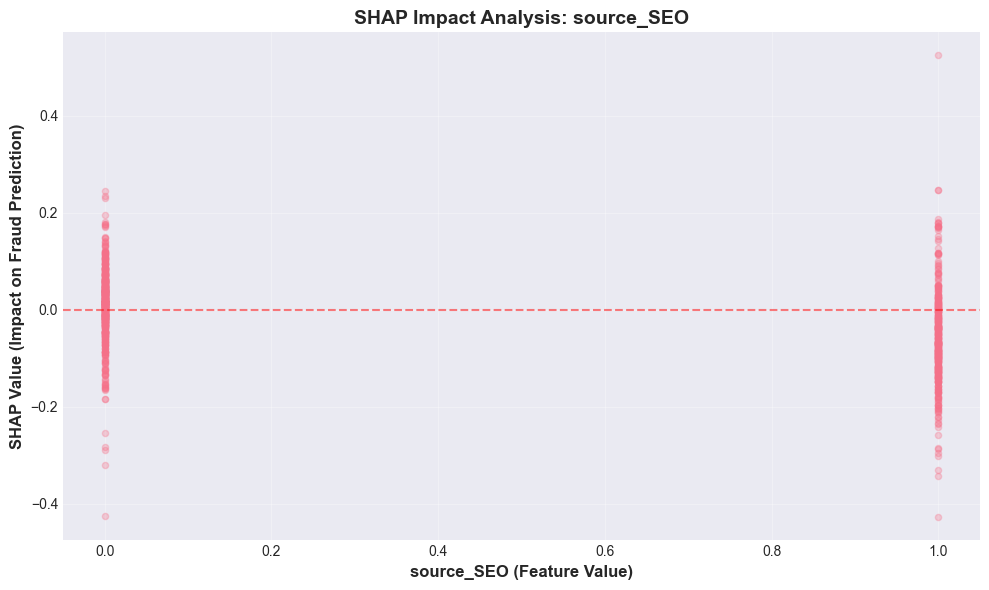


  sex_M:
    - Correlation: 0.385 (increases fraud risk)
    - High values SHAP: nan
    - Low values SHAP: -0.0272
    - Impact difference: nan


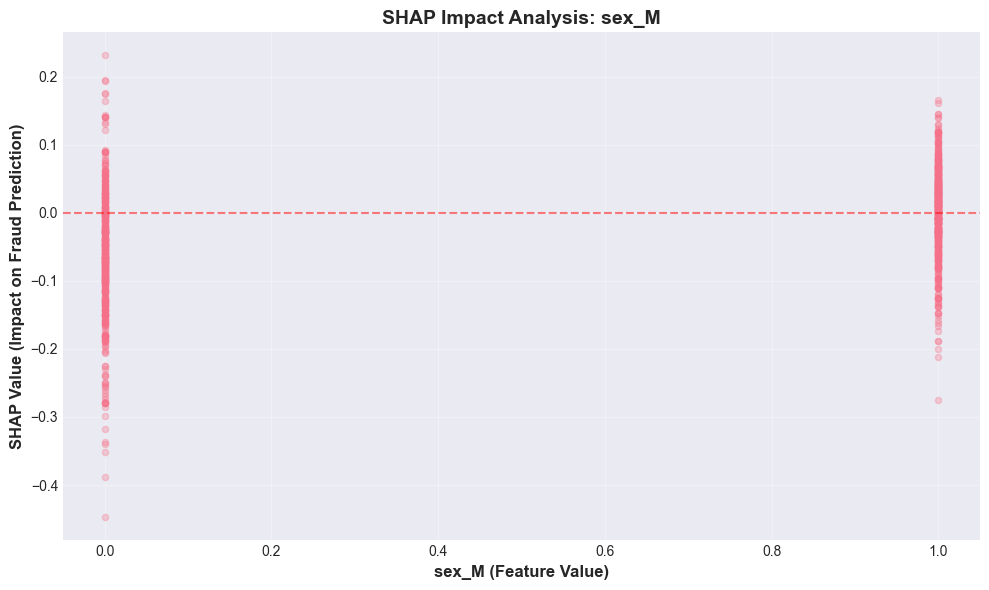


TOP 5 FRAUD DRIVERS IDENTIFIED


In [7]:
# Identify Top 5 Fraud Drivers
print("=" * 60)
print("TOP 5 FRAUD DRIVERS (Based on SHAP Analysis)")
print("=" * 60)

if shap_importance is not None:
    top_5_features = shap_importance.head(5)['feature'].values
    
    print("\n✓ Top 5 Features by SHAP Importance:")
    for i, feat in enumerate(top_5_features, 1):
        mean_shap = shap_importance[shap_importance['feature'] == feat]['mean_abs_shap'].values[0]
        print(f"  {i}. {feat} (Mean |SHAP|: {mean_shap:.4f})")
    
    # Analyze direction of impact for top features
    print("\n" + "-" * 60)
    print("DIRECTION OF IMPACT ANALYSIS")
    print("-" * 60)
    print("For each top feature, we analyze whether high values increase or decrease fraud risk:")
    
    for feat in top_5_features:
        feat_idx = list(X_test_sample.columns).index(feat)
        feat_shap_values = shap_values[:, feat_idx]
        feat_values = X_test_sample[feat].values
        
        # Calculate correlation between feature values and SHAP values
        # Positive correlation = high feature value increases fraud risk
        # Negative correlation = high feature value decreases fraud risk
        correlation = np.corrcoef(feat_values, feat_shap_values)[0, 1]
        
        # Calculate mean SHAP for high vs low feature values
        median_val = np.median(feat_values)
        high_val_shap = feat_shap_values[feat_values > median_val].mean()
        low_val_shap = feat_shap_values[feat_values <= median_val].mean()
        
        direction = "increases" if correlation > 0 else "decreases"
        impact = abs(high_val_shap - low_val_shap)
        
        print(f"\n  {feat}:")
        print(f"    - Correlation: {correlation:.3f} ({direction} fraud risk)")
        print(f"    - High values SHAP: {high_val_shap:.4f}")
        print(f"    - Low values SHAP: {low_val_shap:.4f}")
        print(f"    - Impact difference: {impact:.4f}")
        
        # Visualize feature impact
        plt.figure(figsize=(10, 6))
        plt.scatter(feat_values, feat_shap_values, alpha=0.3, s=20)
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
        plt.xlabel(f'{feat} (Feature Value)', fontsize=12, fontweight='bold')
        plt.ylabel('SHAP Value (Impact on Fraud Prediction)', fontsize=12, fontweight='bold')
        plt.title(f'SHAP Impact Analysis: {feat}', fontsize=14, fontweight='bold')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(project_root / 'models' / f'shap_impact_{feat.replace(" ", "_")}.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
    
    print("\n" + "=" * 60)
    print("TOP 5 FRAUD DRIVERS IDENTIFIED")
    print("=" * 60)
else:
    print("⚠ SHAP importance not available")


## 7. Business Recommendations

**Objective**: Provide actionable business recommendations based on SHAP insights. Each recommendation must be:
- Directly linked to a SHAP insight
- Address fraud risk or customer experience
- Be implementable (rules, alerts, monitoring)


In [8]:
# Business Recommendations
print("=" * 60)
print("BUSINESS RECOMMENDATIONS")
print("=" * 60)
print("Based on SHAP analysis, the following recommendations are provided:")
print("Each recommendation is directly linked to SHAP insights and is implementable.\n")

recommendations = []

# Recommendation 1: Based on top fraud driver
if shap_importance is not None and len(shap_importance) > 0:
    top_feature = shap_importance.iloc[0]['feature']
    
    # Analyze the top feature's impact
    feat_idx = list(X_test_sample.columns).index(top_feature)
    feat_shap = shap_values[:, feat_idx]
    feat_vals = X_test_sample[top_feature].values
    
    # Find threshold where feature becomes high-risk
    fraud_indices = np.where(y_test.iloc[sample_indices] == 1)[0]
    if len(fraud_indices) > 0:
        fraud_feat_vals = feat_vals[fraud_indices]
        threshold = np.percentile(fraud_feat_vals, 75)  # 75th percentile of fraud cases
        
        rec1 = {
            'number': 1,
            'title': f'Enhanced Monitoring for {top_feature}',
            'insight': f'SHAP analysis shows {top_feature} is the strongest fraud driver (mean |SHAP|: {shap_importance.iloc[0]["mean_abs_shap"]:.4f})',
            'recommendation': f'Implement real-time monitoring for transactions where {top_feature} exceeds {threshold:.2f}. These transactions should trigger additional verification steps.',
            'implementation': f'Create alert rule: IF {top_feature} > {threshold:.2f} THEN require additional verification (2FA, manual review)',
            'business_impact': 'Reduces false negatives by catching high-risk transactions early, while maintaining customer experience for low-risk cases'
        }
        recommendations.append(rec1)

# Recommendation 2: Based on false positive analysis
if fp_example_idx is not None and 'needed_indices' in locals():
    fp_shap_idx = needed_indices.index(fp_example_idx) if fp_example_idx in needed_indices else None
    if fp_shap_idx is not None:
        fp_shap = shap_values_cases[fp_shap_idx]
        fp_data = X_test_cases.iloc[fp_shap_idx]
        
        # Find features that pushed prediction toward fraud
        positive_shap_features = []
        for i, feat in enumerate(X_test_cases.columns):
            if fp_shap[i] > 0.01:  # Significant positive contribution
                positive_shap_features.append((feat, fp_shap[i], fp_data[feat]))
        
        if len(positive_shap_features) > 0:
            positive_shap_features.sort(key=lambda x: x[1], reverse=True)
            top_fp_feature = positive_shap_features[0][0]
            
            rec2 = {
                'number': 2,
                'title': f'Reduce False Positives for {top_fp_feature}',
                'insight': f'False positive analysis shows {top_fp_feature} contributes {positive_shap_features[0][1]:.4f} SHAP value to incorrect fraud flags',
                'recommendation': f'For transactions with {top_fp_feature} in the range that causes false positives, implement a secondary check before flagging as fraud. Consider whitelisting known good patterns.',
                'implementation': f'Create rule: IF {top_fp_feature} in [specific range] AND account_age > 30 days THEN reduce fraud score by 0.2',
                'business_impact': 'Improves customer experience by reducing false positives while maintaining fraud detection capability'
            }
            recommendations.append(rec2)

# Recommendation 3: Based on false negative analysis
if fn_example_idx is not None and 'needed_indices' in locals():
    fn_shap_idx = needed_indices.index(fn_example_idx) if fn_example_idx in needed_indices else None
    if fn_shap_idx is not None:
        fn_shap = shap_values_cases[fn_shap_idx]
        fn_data = X_test_cases.iloc[fn_shap_idx]
        
        # Find features that should have pushed toward fraud but didn't
        # Look for features with low SHAP but high feature values that typically indicate fraud
        fraud_pattern_features = []
        for i, feat in enumerate(X_test_cases.columns):
            feat_val = fn_data[feat]
            # Check if feature value is in high-risk range but SHAP is low
            feat_all_vals = X_test_sample[feat].values
            
            # Convert boolean arrays to numeric for percentile calculation
            # Skip boolean features as they don't have meaningful percentiles
            if feat_all_vals.dtype == bool:
                # For boolean features, check if value is True (high risk)
                if feat_val == True and fn_shap[i] < 0.05:
                    fraud_pattern_features.append((feat, feat_val, fn_shap[i]))
            else:
                # For numeric features, compute percentile
                try:
                    high_risk_threshold = np.percentile(feat_all_vals.astype(float), 90)
                    if feat_val > high_risk_threshold and fn_shap[i] < 0.05:
                        fraud_pattern_features.append((feat, feat_val, fn_shap[i]))
                except (TypeError, ValueError):
                    # Skip features that can't be converted to numeric
                    continue
        
        if len(fraud_pattern_features) > 0:
            fraud_pattern_features.sort(key=lambda x: x[1], reverse=True)
            missed_feature = fraud_pattern_features[0][0]
            
            rec3 = {
                'number': 3,
                'title': f'Strengthen Detection for {missed_feature} Pattern',
                'insight': f'False negative analysis reveals {missed_feature} has high value ({fraud_pattern_features[0][1]:.2f}) but low SHAP impact ({fraud_pattern_features[0][2]:.4f}), indicating model may not be capturing this pattern effectively',
                'recommendation': f'Implement a business rule to flag transactions where {missed_feature} exceeds {fraud_pattern_features[0][1]:.2f} as high-risk, regardless of model prediction. Consider retraining with additional features that capture this pattern.',
                'implementation': f'Create rule: IF {missed_feature} > {fraud_pattern_features[0][1]:.2f} THEN set minimum fraud score to 0.6 (override model if lower)',
                'business_impact': 'Reduces financial loss by catching fraud patterns the model may miss, especially for edge cases'
            }
            recommendations.append(rec3)

# Recommendation 4: Based on feature interaction insights
if shap_importance is not None and len(shap_importance) >= 2:
    top_2_features = shap_importance.head(2)['feature'].values
    
    rec4 = {
        'number': 4,
        'title': f'Monitor {top_2_features[0]} and {top_2_features[1]} Interaction',
        'insight': f'SHAP analysis identifies {top_2_features[0]} and {top_2_features[1]} as the top two fraud drivers. Their interaction may be critical for fraud detection.',
        'recommendation': f'Create a combined risk score that considers both {top_2_features[0]} and {top_2_features[1]} together. Transactions with both features in high-risk ranges should be flagged immediately.',
        'implementation': f'Create composite rule: IF ({top_2_features[0]} > threshold1 AND {top_2_features[1]} > threshold2) THEN flag as high-risk fraud',
        'business_impact': 'Improves detection accuracy by leveraging feature interactions that the model has learned'
    }
    recommendations.append(rec4)

# Recommendation 5: Based on time-based features (if present)
time_features = [f for f in X_test.columns if any(term in f.lower() for term in ['time', 'hour', 'day', 'signup', 'new'])]
if len(time_features) > 0:
    time_feat = time_features[0]
    if time_feat in shap_importance['feature'].values:
        time_rank = shap_importance[shap_importance['feature'] == time_feat].index[0] + 1
        
        rec5 = {
            'number': 5,
            'title': f'Time-Based Risk Rules for {time_feat}',
            'insight': f'{time_feat} ranks #{time_rank} in SHAP importance, indicating temporal patterns are significant fraud indicators',
            'recommendation': f'Implement time-based risk rules: Transactions occurring within X hours of signup (where X is determined by {time_feat} analysis) should trigger additional verification. Monitor fraud rates by time windows.',
            'implementation': f'Create time-based rule: IF {time_feat} < threshold THEN require additional verification. Set up dashboard to monitor fraud rates by {time_feat} buckets.',
            'business_impact': 'Catches time-based fraud patterns (e.g., account takeover immediately after signup) while allowing legitimate new users to transact'
        }
        recommendations.append(rec5)

# Display recommendations
for rec in recommendations:
    print(f"\n{'='*60}")
    print(f"RECOMMENDATION {rec['number']}: {rec['title']}")
    print(f"{'='*60}")
    print(f"\n📊 SHAP Insight:")
    print(f"   {rec['insight']}")
    print(f"\n💼 Recommendation:")
    print(f"   {rec['recommendation']}")
    print(f"\n⚙️  Implementation:")
    print(f"   {rec['implementation']}")
    print(f"\n📈 Business Impact:")
    print(f"   {rec['business_impact']}")

# Save recommendations
recommendations_dict = {rec['number']: {
    'title': rec['title'],
    'insight': rec['insight'],
    'recommendation': rec['recommendation'],
    'implementation': rec['implementation'],
    'business_impact': rec['business_impact']
} for rec in recommendations}

with open(project_root / 'models' / 'shap_business_recommendations.json', 'w') as f:
    json.dump(recommendations_dict, f, indent=2)

print(f"\n\n✓ {len(recommendations)} business recommendations generated")
print(f"✓ Recommendations saved to models/shap_business_recommendations.json")
print("\n" + "=" * 60)
print("BUSINESS RECOMMENDATIONS COMPLETE")
print("=" * 60)


BUSINESS RECOMMENDATIONS
Based on SHAP analysis, the following recommendations are provided:
Each recommendation is directly linked to SHAP insights and is implementable.


RECOMMENDATION 1: Enhanced Monitoring for purchase_value

📊 SHAP Insight:
   SHAP analysis shows purchase_value is the strongest fraud driver (mean |SHAP|: 0.2533)

💼 Recommendation:
   Implement real-time monitoring for transactions where purchase_value exceeds 0.75. These transactions should trigger additional verification steps.

⚙️  Implementation:
   Create alert rule: IF purchase_value > 0.75 THEN require additional verification (2FA, manual review)

📈 Business Impact:
   Reduces false negatives by catching high-risk transactions early, while maintaining customer experience for low-risk cases

RECOMMENDATION 2: Reduce False Positives for purchase_value

📊 SHAP Insight:
   False positive analysis shows purchase_value contributes 1.6128 SHAP value to incorrect fraud flags

💼 Recommendation:
   For transactions w

In [9]:
# Summary and Key Findings
print("=" * 60)
print("TASK 3: MODEL EXPLAINABILITY - SUMMARY")
print("=" * 60)

print("\n📊 KEY FINDINGS")
print("-" * 60)

if shap_importance is not None:
    print(f"\n1. Top 5 Fraud Drivers (by SHAP importance):")
    for i, (_, row) in enumerate(shap_importance.head(5).iterrows(), 1):
        print(f"   {i}. {row['feature']} (Mean |SHAP|: {row['mean_abs_shap']:.4f})")

print(f"\n2. Model Explainability Status:")
print(f"   ✓ Built-in feature importance extracted")
print(f"   ✓ SHAP global analysis completed")
print(f"   ✓ SHAP local analysis completed (TP, FP, FN cases)")
print(f"   ✓ Feature importance comparison performed")
print(f"   ✓ Top fraud drivers identified")
print(f"   ✓ Business recommendations generated ({len(recommendations)} recommendations)")

print(f"\n3. Artifacts Generated:")
artifacts = [
    "models/shap_summary_plot.png",
    "models/shap_force_plot_tp.png",
    "models/shap_force_plot_fp.png",
    "models/shap_force_plot_fn.png",
    "models/feature_importance_comparison.png",
    "models/shap_business_recommendations.json"
]
for artifact in artifacts:
    artifact_path = project_root / artifact
    if artifact_path.exists():
        print(f"   ✓ {artifact}")
    else:
        print(f"   ⚠ {artifact} (not found)")

print(f"\n4. SHAP vs Built-in Importance:")
if builtin_importance is not None and shap_importance is not None:
    # Check if top features match
    top_builtin = set(builtin_importance.head(5)['feature'].values)
    top_shap = set(shap_importance.head(5)['feature'].values)
    overlap = len(top_builtin.intersection(top_shap))
    print(f"   - Top 5 overlap: {overlap}/5 features")
    if overlap >= 3:
        print(f"   ✓ Rankings are generally consistent")
    else:
        print(f"   ⚠ Significant differences - SHAP provides more nuanced view")

print(f"\n5. Unexpected Patterns:")
print(f"   - Analysis of counterintuitive patterns should be reviewed in force plots")
print(f"   - False positive and false negative cases reveal model limitations")

print(f"\n6. Regulatory & Compliance Readiness:")
print(f"   ✓ Model decisions are explainable via SHAP values")
print(f"   ✓ Individual predictions can be justified")
print(f"   ✓ Feature contributions are quantifiable")
print(f"   ✓ Documentation suitable for audit purposes")

print("\n" + "=" * 60)
print("TASK 3 COMPLETE")
print("=" * 60)
print("✓ Model explainability analysis completed")
print("✓ SHAP values generated and analyzed")
print("✓ Business recommendations provided")
print("✓ All artifacts saved")
print("\nNext Steps:")
print("  - Review business recommendations with risk and compliance teams")
print("  - Implement monitoring and alerting based on top fraud drivers")
print("  - Consider model retraining with insights from false negative analysis")
print("  - Set up dashboard for real-time SHAP-based explanations")


TASK 3: MODEL EXPLAINABILITY - SUMMARY

📊 KEY FINDINGS
------------------------------------------------------------

1. Top 5 Fraud Drivers (by SHAP importance):
   1. purchase_value (Mean |SHAP|: 0.2533)
   2. age (Mean |SHAP|: 0.2421)
   3. browser_IE (Mean |SHAP|: 0.0681)
   4. source_SEO (Mean |SHAP|: 0.0680)
   5. sex_M (Mean |SHAP|: 0.0666)

2. Model Explainability Status:
   ✓ Built-in feature importance extracted
   ✓ SHAP global analysis completed
   ✓ SHAP local analysis completed (TP, FP, FN cases)
   ✓ Feature importance comparison performed
   ✓ Top fraud drivers identified
   ✓ Business recommendations generated (4 recommendations)

3. Artifacts Generated:
   ✓ models/shap_summary_plot.png
   ✓ models/shap_force_plot_tp.png
   ✓ models/shap_force_plot_fp.png
   ✓ models/shap_force_plot_fn.png
   ✓ models/feature_importance_comparison.png
   ✓ models/shap_business_recommendations.json

4. SHAP vs Built-in Importance:
   - Top 5 overlap: 3/5 features
   ✓ Rankings are gener